# 1. Imports and Configuration
Import necessary libraries and suppress warnings for cleaner output.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
import lightgbm as lgb
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, KFold
import xgboost as xgb
from lightgbm import LGBMClassifier
import warnings
from scipy.stats import skew

warnings.filterwarnings('ignore')

# 2. Load Data
Load the training, test, and sample submission CSV files.

In [4]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
submission = pd.read_csv('sample_submission.csv')

# 3. Exploratory Data Analysis (EDA)
Overview of the exploratory steps performed in this notebook.

## 3.1 Preview Training Data
Preview the first rows of the training data to understand columns and types.

In [5]:
pd.set_option('display.max_columns', None)
train.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


## 3.2 Remove ID and Check Shapes
Remove the id column from both datasets and confirm their shapes.

In [6]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

print(f"df Train shape {train.shape}")
print(f"df Test shape {test.shape}")

df Train shape (593994, 12)
df Test shape (254569, 11)


## 3.3 Data Quality Checks
Check for missing values and duplicate rows in train and test.

In [7]:
print("Number of null value in Train DataFrames : ",train.isna().sum().sum())
print("Number of null value in Test DataFrames : ",test.isna().sum().sum())
print("Number of Duplicated Row in Train DataFrames : ", train.duplicated().sum())
print("Number of Duplicated Row in Test DataFrames : ", test.duplicated().sum())

Number of null value in Train DataFrames :  0
Number of null value in Test DataFrames :  0
Number of Duplicated Row in Train DataFrames :  0
Number of Duplicated Row in Test DataFrames :  0


## 3.4 Identify Feature Types
List numerical and categorical columns.

In [8]:
num_cols = train.select_dtypes(exclude= 'object').columns
cat_cols = train.select_dtypes(include= 'object').columns

print('Numerical columns :', ', '.join(num_cols))
print("Number of numerical columns:" ,len(num_cols))
print("")
print('Categorical columns :', ', '.join(cat_cols))
print("Number of categorical columns:" ,len(cat_cols))

Numerical columns : annual_income, debt_to_income_ratio, credit_score, loan_amount, interest_rate, loan_paid_back
Number of numerical columns: 6

Categorical columns : gender, marital_status, education_level, employment_status, loan_purpose, grade_subgrade
Number of categorical columns: 6


# 4. Descriptive Statistics and Visualization
Compute summary statistics and visualize relationships/outliers.

## 4.1 Summary Statistics (Numerical)
Summary statistics for numerical features.

In [9]:
train[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


Note: Inspect the Python type of the numerical columns index.

In [10]:
type(num_cols)

pandas.core.indexes.base.Index

## 4.2 Correlation Heatmap
Correlation heatmap for numerical features and the target.

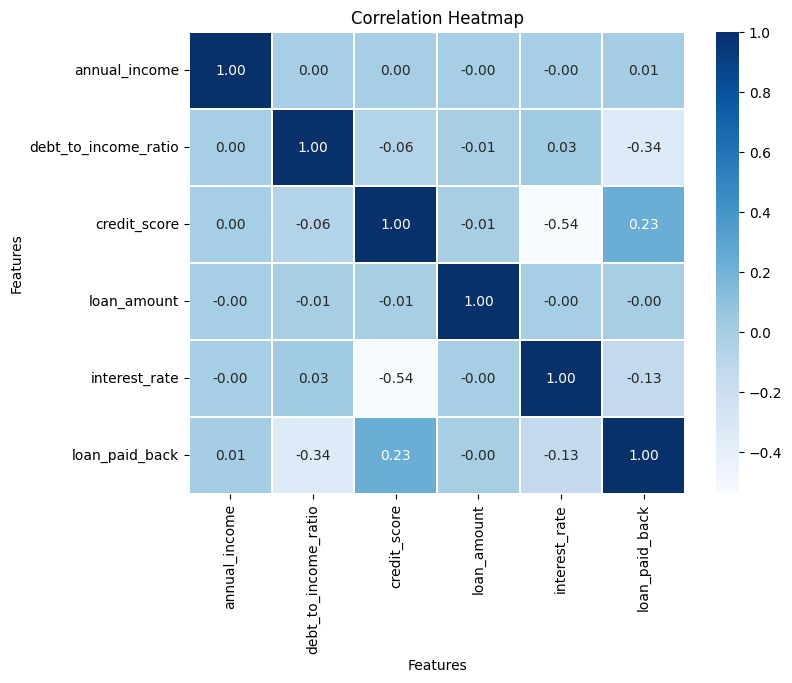

In [11]:
plt.figure(figsize=(8, 6))
correlation_matrix = train[num_cols ].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.1, cmap="Blues")
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

Note: Exclude the target column from the numerical columns list.

In [12]:
num_cols=num_cols.drop('loan_paid_back')

## 4.3 Distributions and Boxplots
Visualize distributions and boxplots to inspect outliers.

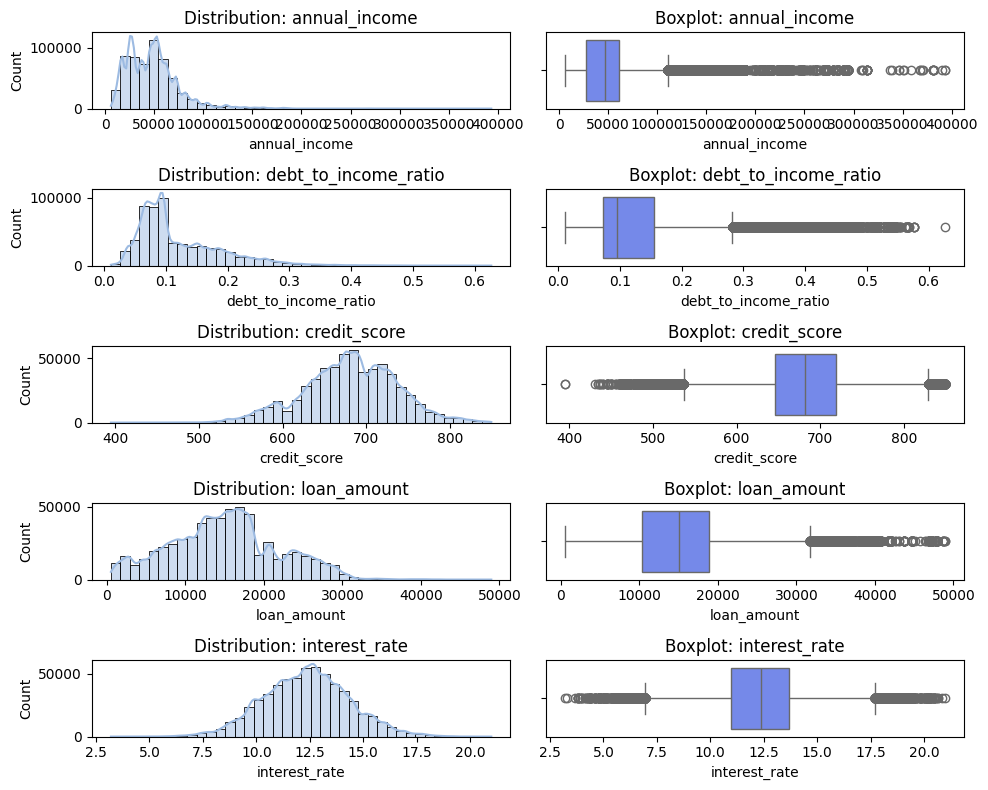

In [13]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 2, 2*i - 1)
    sns.histplot(train[col], kde=True, bins=40, color="#9dbbe2")
    plt.title(f'Distribution: {col}')

    plt.subplot(len(num_cols), 2, 2*i)
    sns.boxplot(x=train[col], color="#627cfc")
    plt.title(f'Boxplot: {col}')

plt.tight_layout()
plt.show()

## 4.4 Feature Skewness
Compute and plot skewness of numerical features.

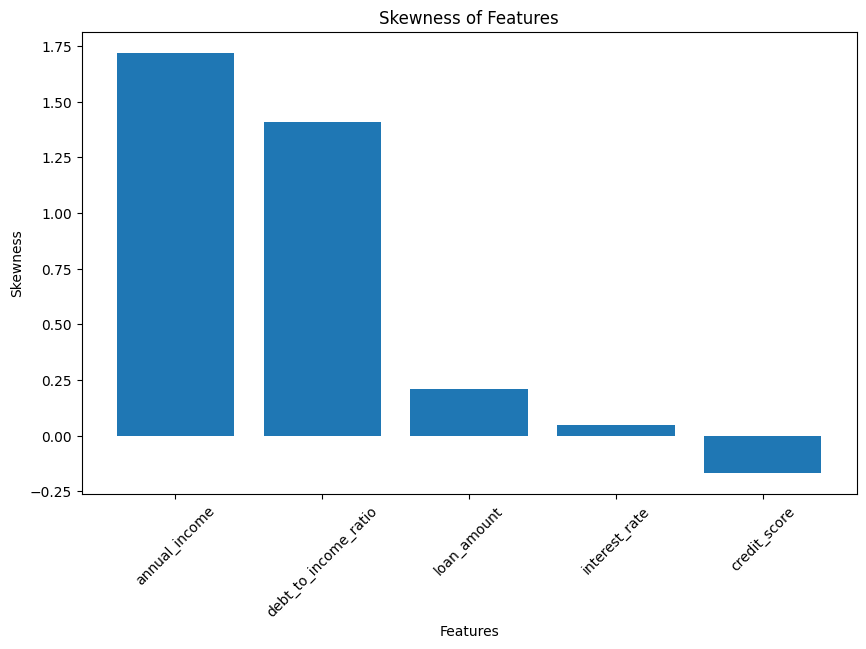

annual_income           1.719509
debt_to_income_ratio    1.406680
loan_amount             0.207360
interest_rate           0.049945
credit_score           -0.166993
dtype: float64


In [14]:
skew_values = train[num_cols].apply(lambda s: skew(s.dropna(), bias=False))
sorted_skew_values = skew_values.sort_values(ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(sorted_skew_values.index, sorted_skew_values.values)
plt.title('Skewness of Features')
plt.xlabel('Features')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.show()
print(sorted_skew_values)

In [15]:
right_skewed_cols = skew_values[skew_values > 1].index.tolist()

print("Highly skewed columns:", ', '.join(right_skewed_cols))

for col in right_skewed_cols:
    train[col] = np.log1p(train[col])
    test[col]  = np.log1p(test[col])

print("Log transformation applied to highly skewed columns.")



Highly skewed columns: annual_income, debt_to_income_ratio
Log transformation applied to highly skewed columns.


## 4.5 Outlier Handling (IQR Clipping)
Clip outliers using the IQR method to reduce the impact of extreme values.

In [16]:
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train[col] = train[col].clip(lower=lower_bound, upper=upper_bound)
    test[col] = test[col].clip(lower=lower_bound, upper=upper_bound)
print("Outliers removed using IQR method.")

Outliers removed using IQR method.


## 4.6 Train vs Test Distribution Shift
Compare distributions of key numerical features between train and test to check for shifts.

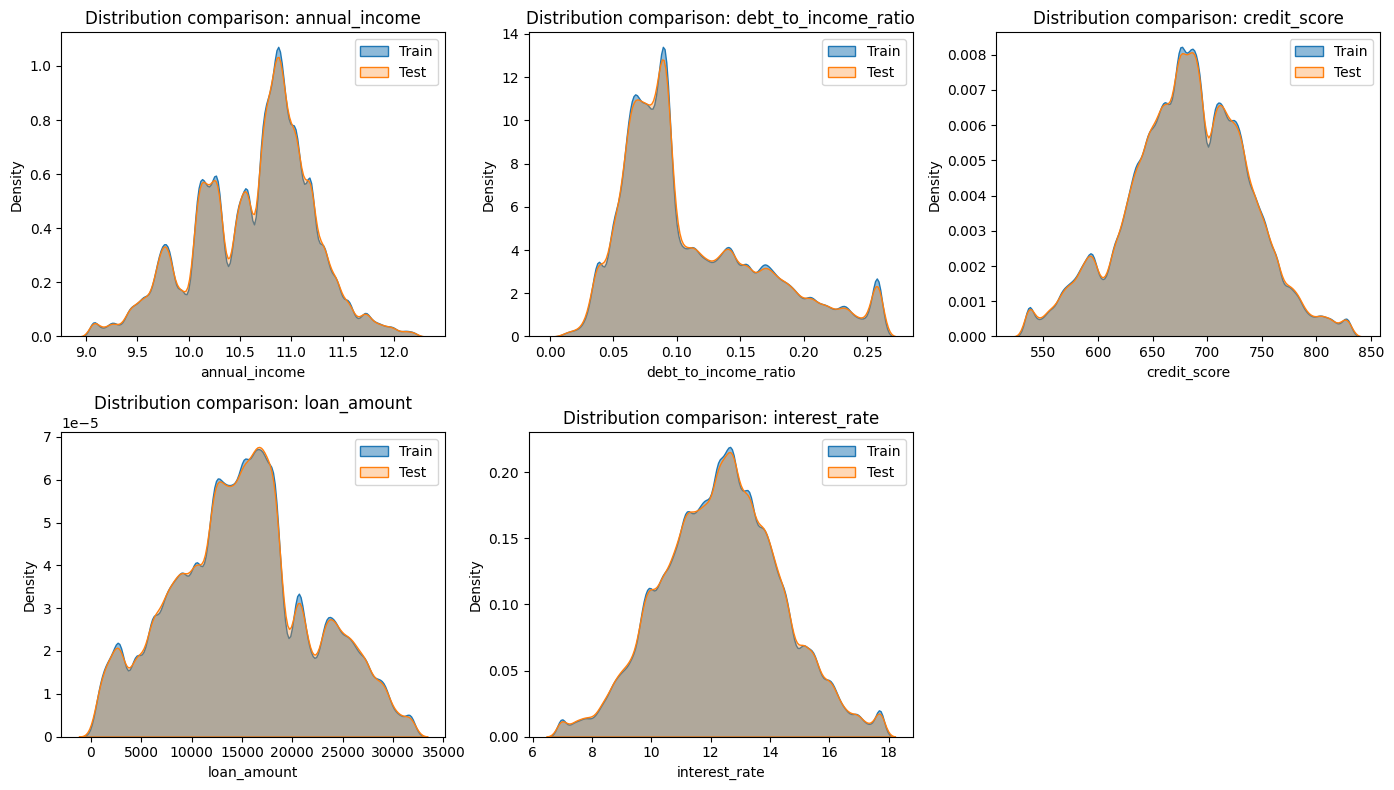

In [17]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(train[col], label='Train', fill=True, alpha=0.5)
    sns.kdeplot(test[col], label='Test', fill=True, alpha=0.3)
    plt.title(f'Distribution comparison: {col}')
    plt.legend()
plt.tight_layout()
plt.show()

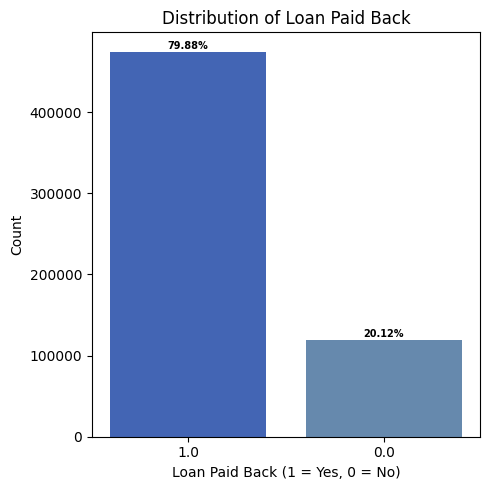

In [18]:
target_counts = train['loan_paid_back'].value_counts()
target_percent = train['loan_paid_back'].value_counts(normalize=True) * 100


plt.figure(figsize=(5,5))
bars = plt.bar(target_counts.index.astype(str),
               target_counts.values,
               color=["#4365b4","#6689ad"])

for bar in bars:
    height = bar.get_height()
    percent = (height / target_counts.sum()) * 100
    plt.text(bar.get_x() + bar.get_width()/2, height + 1000,  # adjust '1000' if scale differs
             f'{percent:.2f}%', ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.title('Distribution of Loan Paid Back')
plt.xlabel('Loan Paid Back (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4.7 Target Imbalance
This dataset is moderately imbalanced (roughly 80% repaid vs 20% default). A model that always predicts repaid would score high accuracy but poor ROC-AUC, so ranking ability matters more than raw accuracy.

## 4.8 Categorical Features: Frequency and Repayment Rate
For each categorical feature, print category frequency and repayment rate (mean of the target), then visualize the repayment rate with a bar chart.


 Feature: gender

Summary:
         Count  Repayment_Rate
gender                        
Female  306175        0.801708
Male    284091        0.795752
Other     3728        0.795333


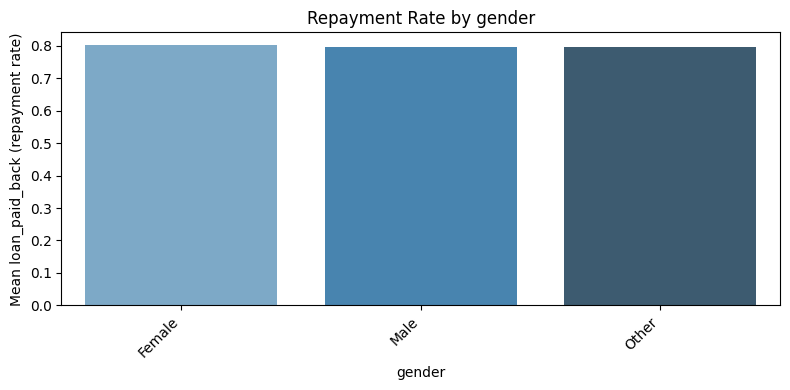


 Feature: marital_status

Summary:
                 Count  Repayment_Rate
marital_status                        
Single          288843        0.798873
Married         277239        0.799144
Divorced         21312        0.796640
Widowed           6600        0.789848


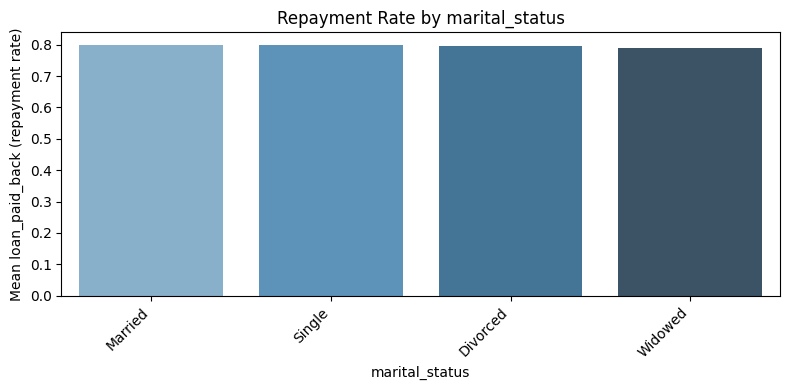


 Feature: education_level

Summary:
                  Count  Repayment_Rate
education_level                        
Bachelor's       279606        0.788892
High School      183592        0.809698
Master's          93097        0.802346
Other             26677        0.802789
PhD               11022        0.830067


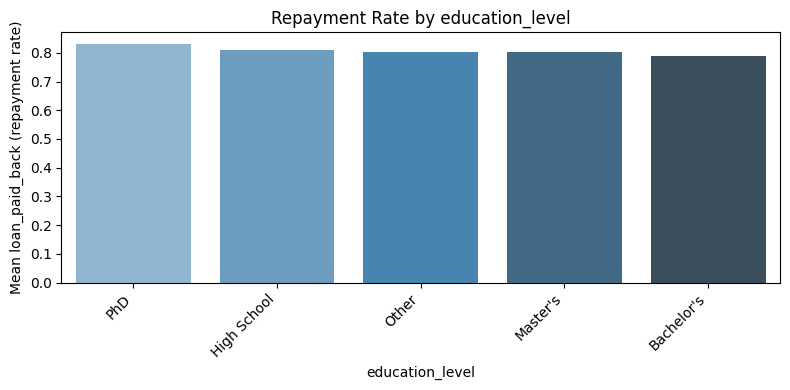


 Feature: employment_status

Summary:
                    Count  Repayment_Rate
employment_status                        
Employed           450645        0.894145
Unemployed          62485        0.077619
Self-employed       52480        0.898457
Retired             16453        0.997204
Student             11931        0.263515


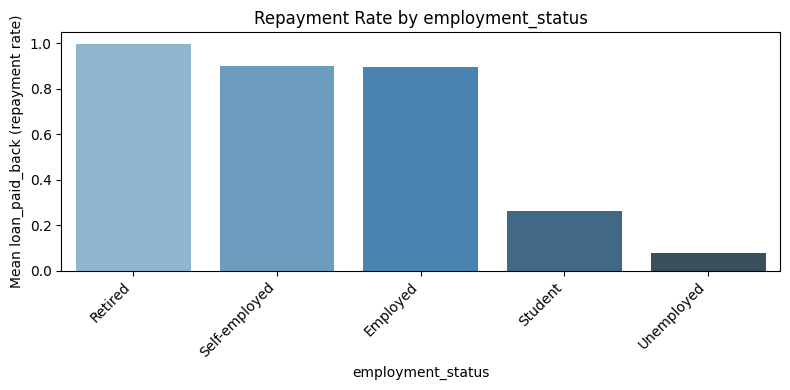


 Feature: loan_purpose

Summary:
                     Count  Repayment_Rate
loan_purpose                              
Debt consolidation  324695        0.796911
Other                63874        0.802377
Car                  58108        0.800630
Home                 44118        0.823224
Education            36641        0.777053
Business             35303        0.813104
Medical              22806        0.778085
Vacation              8449        0.796071


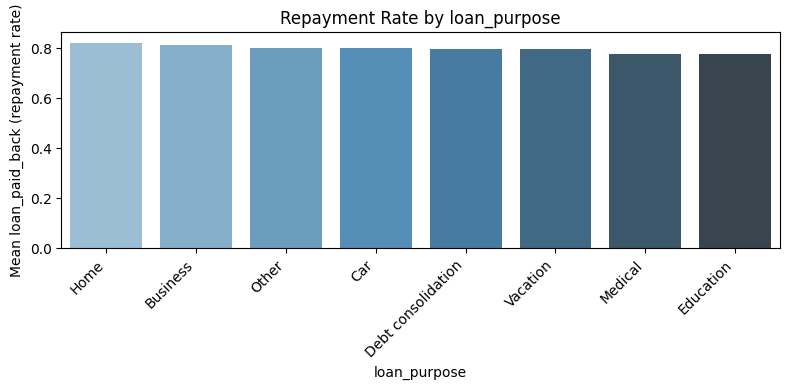


 Feature: grade_subgrade

Summary:
                Count  Repayment_Rate
grade_subgrade                       
C3              58695        0.836000
C4              55957        0.843987
C2              54443        0.851165
C1              53363        0.860090
C5              53317        0.846259
D1              37029        0.731886
D3              36694        0.695972
D4              35097        0.714733
D2              34432        0.720957
D5              32101        0.713000
B2              15167        0.937430
B1              14344        0.916341
B5              13937        0.934204
B3              13926        0.940040
B4              13877        0.931758
E4               8036        0.649577
E3               7075        0.641837
E1               6891        0.652010
E2               6372        0.662743
E5               6084        0.669461
F5               5947        0.639314
F4               5535        0.637037
F1               5534        0.624503
F2            

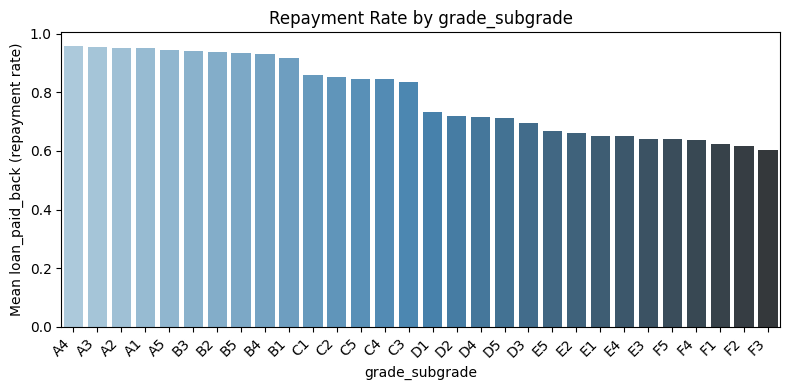

In [19]:
for col in cat_cols:
    print(f"\n Feature: {col}")

    freq = train[col].value_counts(dropna=False)
    repayment_rate = train.groupby(col)['loan_paid_back'].mean().sort_values(ascending=False)

    summary = pd.concat([freq, repayment_rate], axis=1)
    summary.columns = ['Count', 'Repayment_Rate']
    print("\nSummary:")
    print(summary)

    plt.figure(figsize=(8,4))
    
    sns.barplot(
        x=repayment_rate.index,
        y=repayment_rate.values,
        palette="Blues_d"
    )
    plt.title(f'Repayment Rate by {col}')
    plt.ylabel('Mean loan_paid_back (repayment rate)')
    plt.xlabel(col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [20]:
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,10.287695,0.080658,736.0,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,10.003741,0.153579,636.0,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,10.811085,0.092579,694.0,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,10.754904,0.062975,536.5,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,10.146344,0.051643,665.0,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


# 5. Feature Engineering
Create domain-inspired features (ratios, interactions, logarithms) to enrich the signal for the model.

## 5.1 Create Features
Generate domain-inspired features (ratios, interactions, logarithms) that may improve model signal.

In [21]:
train['loan_to_income'] = train['loan_amount'] / (train['annual_income'] + 1)
test['loan_to_income'] = test['loan_amount'] / (test['annual_income'] + 1)

train['total_debt'] = train['debt_to_income_ratio'] * train['annual_income']
test['total_debt'] = test['debt_to_income_ratio'] * test['annual_income']

train['available_income'] = train['annual_income'] * (1 - train['debt_to_income_ratio'])
test['available_income'] = test['annual_income'] * (1 - test['debt_to_income_ratio'])

train['affordability'] = train['available_income'] / (train['loan_amount'] + 1)
test['affordability'] = test['available_income'] / (test['loan_amount'] + 1)

train['monthly_payment'] = train['loan_amount'] * (1 + train['interest_rate']/100) / 12
test['monthly_payment'] = test['loan_amount'] * (1 + test['interest_rate']/100) / 12

train['payment_to_income'] = train['monthly_payment'] / (train['annual_income']/12 + 1)
test['payment_to_income'] = test['monthly_payment'] / (test['annual_income']/12 + 1)

train['risk_score'] = (train['debt_to_income_ratio'] * 40 + (1 - train['credit_score']/850) * 30 + train['interest_rate'] * 2)
test['risk_score'] = (test['debt_to_income_ratio'] * 40 + (1 - test['credit_score']/850) * 30 + test['interest_rate'] * 2)


train['credit_interest'] = train['credit_score'] * train['interest_rate'] / 100
test['credit_interest'] = test['credit_score'] * test['interest_rate'] / 100

train['income_credit'] = np.log1p(train['annual_income']) * train['credit_score'] / 1000
test['income_credit'] = np.log1p(test['annual_income']) * test['credit_score'] / 1000

train['debt_loan'] = train['debt_to_income_ratio'] * np.log1p(train['loan_amount'])
test['debt_loan'] = test['debt_to_income_ratio'] * np.log1p(test['loan_amount'])

train['log_income'] = np.log1p(train['annual_income'])
test['log_income'] = np.log1p(test['annual_income'])

train['log_loan'] = np.log1p(train['loan_amount'])
test['log_loan'] = np.log1p(test['loan_amount'])

print("New features created successfully.")

New features created successfully.


## 5.2 Preview After Feature Engineering
Preview the training data after feature engineering.

In [22]:
train.head()

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,loan_to_income,total_debt,available_income,affordability,monthly_payment,payment_to_income,risk_score,credit_interest,income_credit,debt_loan,log_income,log_loan
0,10.287695,0.080658,736.0,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,223.997909,0.829784,9.457911,0.003739,239.504584,128.952548,34.589846,100.6112,1.783853,0.632015,2.423713,7.835745
1,10.003741,0.153579,636.0,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,417.412589,1.536365,8.467376,0.001843,432.210710,235.711215,39.536105,82.1712,1.525278,1.295060,2.398235,8.432528
2,10.811085,0.092579,694.0,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,1439.761933,1.000881,9.810203,0.000577,1555.404387,818.236088,28.729050,67.7344,1.713513,0.901844,2.469038,9.741330
3,10.754904,0.062975,536.5,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,398.342693,0.677288,10.077616,0.002152,453.029940,238.909351,45.783698,86.3765,1.322081,0.532250,2.464270,8.451797
4,10.146344,0.051643,665.0,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,1093.132467,0.523990,9.622354,0.000790,1119.038359,606.351124,29.015141,67.8965,1.603389,0.485859,2.411112,9.407996


# 6. Preprocessing for Modeling
Prepare features and encodings required by the model.

## 6.1 Prepare Features (X) and Target (y)
Prepare features matrix X and target vector y.

In [23]:
X = train.drop(columns='loan_paid_back',axis=1)
y = train['loan_paid_back']

## 6.2 Encode Categorical Features
Label-encode categorical features so the model can consume them; apply the same mapping to test.

In [24]:
cat_cols = train.select_dtypes(include=["object", "category"]).columns.tolist()

for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    test[col] = le.transform(test[col])

# 7. Model Training (Stratified 5-Fold LightGBM)
Train a LightGBM model using stratified 5-fold cross-validation and report per-fold and overall ROC-AUC.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from lightgbm import LGBMClassifier

params = dict(
    n_estimators=1320,
    learning_rate=0.05,
    num_leaves=93,
    max_depth=5,
    colsample_bytree=0.975,
    subsample=0.743,
    reg_alpha=2.95,
    reg_lambda=0.0022,
    random_state=42,
    n_jobs=-1,
    metric='auc',
    objective='binary',
    boosting_type='gbdt',
    verbosity=-1,
)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_curves, fold_scores = [], []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    print(f"--- Fold {fold}/{skf.n_splits} ---")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    model = LGBMClassifier(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
    )

    val_pred = model.predict_proba(X_val)[:, 1]
    oof_preds[val_idx] = val_pred

    test_preds += model.predict_proba(test)[:, 1] / skf.n_splits

    auc = roc_auc_score(y_val, val_pred)
    fold_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_val, val_pred)
    roc_curves.append((fpr, tpr, auc))

overall_auc = roc_auc_score(y, oof_preds)
print("Fold AUCs:", [round(s, 4) for s in fold_scores])
print(f"Overall OOF AUC: {overall_auc:.5f}")

--- Fold 1/5 ---
Fold 1 AUC: 0.9235
--- Fold 2/5 ---


# 8. Final Model
Fit the final model on the full training data.

In [ ]:
final_model = LGBMClassifier(**params)
final_model.fit(X, y)

# 9. Submission
Create the submission file with predicted probabilities and save to CSV.

In [ ]:
submission['loan_paid_back'] = test_preds
submission.to_csv('submission.csv', index=False)
submission.head()

,id,loan_paid_back
0,593994,0.925548
1,593995,0.978893
2,593996,0.575625
3,593997,0.915538
4,593998,0.960974


# 10. LGM vs XGB

In [ ]:
lgb_params = dict(
    n_estimators=1320,
    learning_rate=0.05,
    num_leaves=93,
    max_depth=5,
    colsample_bytree=0.975,
    subsample=0.743,
    reg_alpha=2.95,
    reg_lambda=0.0022,
    random_state=42,
    n_jobs=-1,
    metric='auc',
    objective='binary',
    boosting_type='gbdt',
    verbosity=-1,
)

xgb_params = dict(
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    max_depth=6,
    learning_rate=0.0669438421783529,
    n_estimators=732,
    min_child_weight=8.368496274182363,
    subsample=0.8638990746572127,
    colsample_bytree=0.9262609574627299,
    gamma=1.9880100566380507,
    reg_alpha=0.010470012214699875,
    reg_lambda=0.010061409517576274,
    max_bin=504,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

lgb_model = LGBMClassifier(**lgb_params)
xgb_model = xgb.XGBClassifier(**xgb_params)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_curves, fold_scores = [], []

for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    print(f"--- Fold {fold}/{skf.n_splits} ---")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    lgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
    )
    lgb_pred = lgb_model.predict_proba(X_val)[:, 1]

    xgb_model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    xgb_pred = xgb_model.predict_proba(X_val)[:, 1]

    val_pred = 0.8 * xgb_pred + 0.2 * lgb_pred

    auc = roc_auc_score(y_val, val_pred)
    fold_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_val, val_pred)
    roc_curves.append((fpr, tpr, auc))

print("Fold AUCs:", [round(s, 4) for s in fold_scores])
simple_avg_score = np.mean(fold_scores)
print(f"\nSimple Average CV Score: {simple_avg_score:.5f} (+/- {np.std(fold_scores):.5f})")


NameError: name 'LGBMClassifier' is not defined

In [ ]:
xgb_pred = xgb_model.predict_proba(test)[:, 1]

ensemble_pred = 0.8 * xgb_pred + 0.2 * lgb_pred

submission['loan_paid_back'] = ensemble_pred
submission.to_csv('submission_test2.csv', index=False)
submission.head()